## 전처리

In [8]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2
import pandas as pd
import ast
from tqdm import tqdm
import re

# ==========================================
# [설정] 경로 및 파라미터
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'

# [입력 1] 원본 DICOM 폴더 (보통 train_images)
# *주의*: 만약 그룹별로 폴더가 나뉘어 있다면 아래 경로 로직 확인 필요
# 여기서는 'train_images'가 원본이라고 가정 (만약 그룹별이라면 코드 내에서 순회)
DICOM_ROOT_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images')
]

# [입력 2] 마스크 폴더
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 

# [입력 3] 원본 라벨 CSV (사용자님이 말씀하신 filtered 파일)
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

# [출력] 저장 경로
OUTPUT_DIR = os.path.join(BASE_DIR, 'detection_cropped_512') 
OUTPUT_MANIFEST = os.path.join(BASE_DIR, 'det_train_manifest_cropped_512.csv')

# 전처리 파라미터
WL, WW = 500, 2000
TARGET_SIZE = 512
MARGIN_RATIO = 0.2 

# ==========================================
# [함수] 유틸리티
# ==========================================
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

def get_mask_bbox(mask_slice):
    rows = np.any(mask_slice > 0, axis=1)
    cols = np.any(mask_slice > 0, axis=0)
    if not np.any(rows) or not np.any(cols): return None
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def make_square_box(x1, y1, x2, y2, img_w, img_h, margin=0.2):
    w = x2 - x1
    h = y2 - y1
    cx, cy = x1 + w // 2, y1 + h // 2
    max_side = max(w, h)
    new_size = int(max_side * (1 + margin))
    half_size = new_size // 2
    new_x1 = max(0, cx - half_size)
    new_y1 = max(0, cy - half_size)
    new_x2 = min(img_w, cx + half_size)
    new_y2 = min(img_h, cy + half_size)
    if new_x2 <= new_x1 or new_y2 <= new_y1: return 0, 0, img_w, img_h
    return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

def get_slice_number(filename):
    """파일명(100.dcm)에서 숫자(100)만 추출"""
    return int(re.search(r'\d+', filename).group())

# ==========================================
# [메인] Reset & Rebuild
# ==========================================
def process_fresh_start():
    # 1. BBox CSV 로드
    if not os.path.exists(BBOX_CSV_PATH):
        print(f"❌ 라벨 파일이 없습니다: {BBOX_CSV_PATH}")
        return
    
    bbox_df = pd.read_csv(BBOX_CSV_PATH)
    # 필요한 컬럼만 추출 (StudyInstanceUID, slice_number, x, y, width, height)
    # filtered 파일에 fracture 컬럼이 있는지 확인 필요. 없다면 bbox가 있으면 골절(1)로 간주.
    print(f"📖 라벨 데이터 로드: {len(bbox_df)} boxes")

    # 2. 처리할 환자 리스트업 (마스크가 있는 환자만)
    available_masks = [f.replace('_mask.nii.gz', '') for f in os.listdir(MASK_DIR) if f.endswith('_mask.nii.gz')]
    uids_to_process = sorted(list(set(available_masks)))
    
    new_rows = []
    
    print(f"🚀 [Fresh Start] 데이터셋 재생성 시작")
    print(f"   - 대상 환자: {len(uids_to_process)}명")
    print(f"   - 저장 경로: {OUTPUT_DIR}")

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    for uid in tqdm(uids_to_process):
        # A. 원본 DICOM 폴더 찾기
        dicom_dir = None
        for root in DICOM_ROOT_DIRS:
            temp_path = os.path.join(root, uid)
            if os.path.exists(temp_path):
                dicom_dir = temp_path
                break
        
        if dicom_dir is None: continue # 원본 이미지 없으면 스킵

        try:
            # B. DICOM 메타데이터 로드 및 Z축 정렬 (핵심!)
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_meta = []
            
            for f in dcm_files:
                # 파일명에서 slice_number 추출 (CSV 매칭용)
                slice_num = get_slice_number(f)
                
                # 메타데이터 읽기 (속도 최적화를 위해 픽셀 건너뜀)
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                
                dcm_meta.append({
                    'filename': f,
                    'full_path': os.path.join(dicom_dir, f),
                    'slice_number': slice_num, # 100.dcm -> 100
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
                    'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
                })
            
            # [중요] Z축 기준 정렬 (머리 -> 다리)
            dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
            
            # C. 전체 볼륨 메모리 로드 (Windowing)
            full_vol = []
            for m in dcm_meta:
                ds = pydicom.dcmread(m['full_path'])
                px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
                full_vol.append(apply_windowing(px, WL, WW))
            full_vol = np.stack(full_vol, axis=0) # (Z, H, W)
            
            # D. 마스크 로드 (NIfTI)
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            mask_itk = sitk.ReadImage(mask_path)
            mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
            mask_vol = np.flip(mask_vol, axis=(0, 1)) # 축 정렬 (SimpleITK vs Numpy)

            # E. 슬라이스별 처리
            patient_save_dir = os.path.join(OUTPUT_DIR, uid)
            os.makedirs(patient_save_dir, exist_ok=True)
            
            # 현재 환자의 BBox 정보 가져오기
            pat_bbox_df = bbox_df[bbox_df['StudyInstanceUID'] == uid]
            
            # 정렬된 dcm_meta 순서대로(0~N) 순회
            for z_idx, meta in enumerate(dcm_meta):
                # 이 슬라이스의 실제 파일 번호 (CSV 매칭키)
                current_slice_num = meta['slice_number']
                
                # 마스크 확인 (해당 Z 인덱스)
                if z_idx >= len(mask_vol): break
                m_slice = mask_vol[z_idx]
                
                # 마스크가 있는 경우만 처리 (데이터 효율성)
                mask_bbox = get_mask_bbox(m_slice)
                if mask_bbox is None: continue
                
                # --- 크롭 좌표 계산 ---
                mx1, my1, mx2, my2 = mask_bbox
                ori_h, ori_w = m_slice.shape
                cx1, cy1, cx2, cy2 = make_square_box(mx1, my1, mx2, my2, ori_w, ori_h, MARGIN_RATIO)
                crop_w, crop_h = cx2 - cx1, cy2 - cy1
                if crop_w == 0: continue
                
                # --- 2.5D 이미지 구성 ---
                z_prev = max(0, z_idx - 1)
                z_next = min(len(full_vol) - 1, z_idx + 1)
                img_3ch = np.stack([full_vol[z_prev], full_vol[z_idx], full_vol[z_next]], axis=0)
                
                # --- 크롭 & 리사이즈 ---
                combined = np.concatenate([img_3ch, m_slice[np.newaxis, ...]], axis=0) # (4, H, W)
                cropped = combined[:, cy1:cy2, cx1:cx2] # Crop
                
                # Transpose for CV2 resize (C,H,W) -> (H,W,C)
                cropped_hwc = np.transpose(cropped, (1, 2, 0))
                resized_hwc = cv2.resize(cropped_hwc, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
                
                # 마스크 채널 정규화 (Optional: C1~C7 값을 0~1로)
                if resized_hwc[:, :, 3].max() > 1:
                     resized_hwc[:, :, 3] = resized_hwc[:, :, 3] / 7.0
                
                final_data = np.transpose(resized_hwc, (2, 0, 1)) # (4, 512, 512)
                
                # --- 정답(BBox) 매칭 ---
                # Key: StudyInstanceUID + slice_number (파일명 숫자)
                # 이 슬라이스 번호에 해당하는 박스가 있는지 확인
                relevant_boxes = pat_bbox_df[pat_bbox_df['slice_number'] == current_slice_num]
                
                is_fracture = 0
                new_bboxes = []
                
                if len(relevant_boxes) > 0:
                    is_fracture = 1
                    scale_x = TARGET_SIZE / crop_w
                    scale_y = TARGET_SIZE / crop_h
                    
                    for _, row in relevant_boxes.iterrows():
                        # 원본 CSV 좌표 (x, y, w, h)
                        bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                        
                        # 이미 Pixel 좌표일 것임 (RSNA BBox CSV는 보통 Pixel 단위)
                        # Transform to Crop Coordinates
                        new_x = (bx - cx1) * scale_x
                        new_y = (by - cy1) * scale_y
                        new_w = bw * scale_x
                        new_h = bh * scale_y
                        
                        # Normalize (0~1) for YOLO
                        norm_x = new_x / TARGET_SIZE
                        norm_y = new_y / TARGET_SIZE
                        norm_w = new_w / TARGET_SIZE
                        norm_h = new_h / TARGET_SIZE
                        
                        # 유효성 검사
                        if (norm_x + norm_w > 0) and (norm_y + norm_h > 0) and (norm_x < 1) and (norm_y < 1):
                            new_bboxes.append([norm_x, norm_y, norm_w, norm_h])
                
                # --- 저장 ---
                # 파일명: 정렬된 순서(z_idx)로 저장할지, 원본 번호(slice_num)로 할지 결정
                # 헷갈리지 않게 z_idx(0000.npz, 0001.npz...)로 저장하는 게 학습에 유리
                file_name = f"{z_idx:04d}.npz" 
                save_path = os.path.join(patient_save_dir, file_name)
                np.savez_compressed(save_path, data=final_data)
                
                # 매니페스트 기록
                new_rows.append({
                    'StudyInstanceUID': uid,
                    'slice_idx': z_idx, # 정렬된 인덱스
                    'original_slice_number': current_slice_num, # 원본 파일 번호 (추적용)
                    'file_path': os.path.join('detection_cropped_512', uid, file_name),
                    'fracture': is_fracture,
                    'bbox': str(new_bboxes),
                    'ver_level': 0 # 필요하면 마스크에서 추출, 일단 0
                })
                
        except Exception as e:
            print(f"❌ Error {uid}: {e}")
            continue

    # 3. 폴드 나누기 및 저장
    df_out = pd.DataFrame(new_rows)
    
    # K-Fold (GroupKFold by UID)
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    df_out['fold'] = -1
    unique_uids = df_out['StudyInstanceUID'].unique()
    
    for f_idx, (_, val_idx) in enumerate(kf.split(unique_uids), 1):
        val_pids = unique_uids[val_idx]
        df_out.loc[df_out['StudyInstanceUID'].isin(val_pids), 'fold'] = f_idx

    df_out.to_csv(OUTPUT_MANIFEST, index=False)
    print(f"\n✨ [Complete] 데이터셋 리셋 완료!")
    print(f"   - 총 슬라이스: {len(df_out)}")
    print(f"   - 골절 슬라이스: {len(df_out[df_out['fracture']==1])}")
    print(f"   - 저장된 매니페스트: {OUTPUT_MANIFEST}")

if __name__ == '__main__':
    process_fresh_start()

📖 라벨 데이터 로드: 7217 boxes
🚀 [Fresh Start] 데이터셋 재생성 시작
   - 대상 환자: 235명
   - 저장 경로: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\detection_cropped_512


100%|██████████| 235/235 [1:45:13<00:00, 26.87s/it]



✨ [Complete] 데이터셋 리셋 완료!
   - 총 슬라이스: 49611
   - 골절 슬라이스: 7190
   - 저장된 매니페스트: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_512.csv


## 전처리 검증

In [4]:
import pandas as pd
import os
import random

# 경로 설정
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

# 원본 이미지가 있는 폴더들 (혹시 1, 3 그룹으로 나뉘어 있다면)
IMAGE_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
    os.path.join(BASE_DIR, 'train_images') # 혹시 원본 폴더가 따로 있다면
]

def verify_slice_numbers():
    if not os.path.exists(BBOX_CSV_PATH):
        print("CSV 파일이 없습니다.")
        return

    df = pd.read_csv(BBOX_CSV_PATH)
    print(f"총 라벨 수: {len(df)}")
    
    # 랜덤하게 10개만 뽑아서 파일이 실존하는지 확인
    samples = df.sample(10)
    
    match_count = 0
    for idx, row in samples.iterrows():
        uid = row['StudyInstanceUID']
        slice_num = row['slice_number']
        
        # 예상되는 파일명
        expected_filename = f"{slice_num}.dcm"
        
        # 실제 파일 찾기
        found = False
        for root in IMAGE_DIRS:
            full_path = os.path.join(root, uid, expected_filename)
            if os.path.exists(full_path):
                found = True
                print(f"✅ 확인됨: UID {uid[:5]}... | Label: {slice_num} -> File: {expected_filename}")
                break
        
        if found:
            match_count += 1
        else:
            print(f"❌ 실패: UID {uid} | Label {slice_num} 에 해당하는 파일({expected_filename})을 못 찾음!")

    if match_count == 10:
        print("\n🎉 검증 완료! 'slice_number'는 'DICOM 파일명'이 확실합니다.")
        print("-> 아까 드린 코드를 그대로 사용하셔도 됩니다.")
    else:
        print("\n⚠️ 경고! 파일명과 번호가 일치하지 않습니다. 매핑 로직 수정이 필요합니다.")

if __name__ == '__main__':
    verify_slice_numbers()

총 라벨 수: 7217
✅ 확인됨: UID 1.2.8... | Label: 231 -> File: 231.dcm
✅ 확인됨: UID 1.2.8... | Label: 102 -> File: 102.dcm
✅ 확인됨: UID 1.2.8... | Label: 143 -> File: 143.dcm
✅ 확인됨: UID 1.2.8... | Label: 212 -> File: 212.dcm
✅ 확인됨: UID 1.2.8... | Label: 108 -> File: 108.dcm
✅ 확인됨: UID 1.2.8... | Label: 233 -> File: 233.dcm
✅ 확인됨: UID 1.2.8... | Label: 274 -> File: 274.dcm
✅ 확인됨: UID 1.2.8... | Label: 158 -> File: 158.dcm
✅ 확인됨: UID 1.2.8... | Label: 234 -> File: 234.dcm
✅ 확인됨: UID 1.2.8... | Label: 209 -> File: 209.dcm

🎉 검증 완료! 'slice_number'는 'DICOM 파일명'이 확실합니다.
-> 아까 드린 코드를 그대로 사용하셔도 됩니다.


📊 전체 라벨 수: 7217


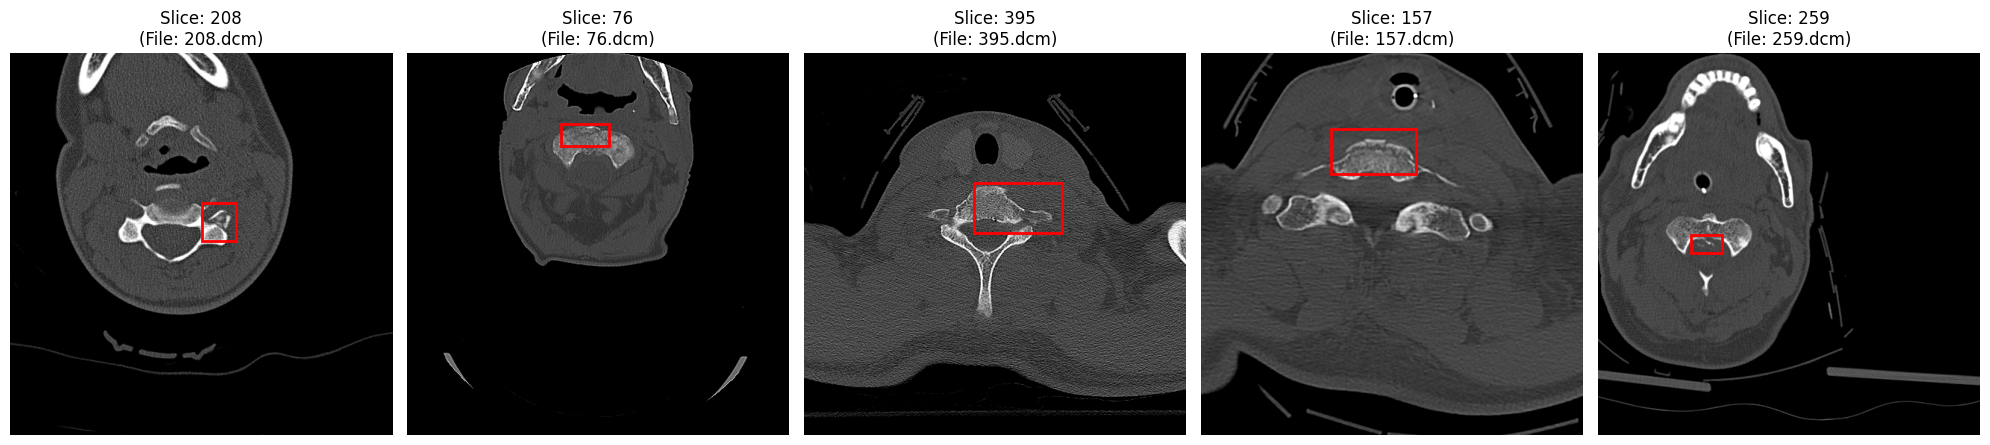

✨ 검증 완료! 빨간 박스가 뼈(하얀 부분) 위에 정확히 있는지 확인하세요.


In [7]:
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob

# ==========================================
# [설정] 경로
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

# 원본 이미지가 들어있을 후보 폴더들
SEARCH_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
    os.path.join(BASE_DIR, 'train_images')
]

# 보기 좋은 뼈 윈도우 설정 (Bone Window)
WL, WW = 500, 2000

def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    img = (img - img_min) / ww
    return img

def find_dicom_path(uid, slice_num):
    """UID와 슬라이스 번호로 실제 파일 경로를 찾습니다."""
    filename = f"{slice_num}.dcm"
    for root in SEARCH_DIRS:
        path = os.path.join(root, uid, filename)
        if os.path.exists(path):
            return path
    return None

def verify_bbox_visual():
    if not os.path.exists(BBOX_CSV_PATH):
        print(f"❌ CSV 파일 없음: {BBOX_CSV_PATH}")
        return

    df = pd.read_csv(BBOX_CSV_PATH)
    print(f"📊 전체 라벨 수: {len(df)}")

    # 랜덤으로 5개만 뽑아서 확인
    samples = df.sample(n=5, random_state=42) # 랜덤 시드 고정 (재현 가능)

    plt.figure(figsize=(20, 5))
    
    for idx, (i, row) in enumerate(samples.iterrows()):
        uid = row['StudyInstanceUID']
        slice_num = int(row['slice_number'])
        
        # 1. 실제 DICOM 파일 찾기
        dcm_path = find_dicom_path(uid, slice_num)
        
        ax = plt.subplot(1, 5, idx + 1)
        
        if dcm_path is None:
            ax.text(0.5, 0.5, "File Not Found", ha='center')
            ax.set_title(f"{uid[:5]}... | Slice {slice_num}")
            continue

        # 2. 이미지 로드 & 윈도잉
        try:
            ds = pydicom.dcmread(dcm_path)
            img = ds.pixel_array.astype(np.float32)
            slope = float(getattr(ds, 'RescaleSlope', 1.0))
            intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
            img = img * slope + intercept
            img_windowed = apply_windowing(img, WL, WW)
            
            ax.imshow(img_windowed, cmap='gray')
            
            # 3. BBox 그리기 (Red)
            # CSV 좌표: x, y, width, height
            x, y, w, h = row['x'], row['y'], row['width'], row['height']
            
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            ax.set_title(f"Slice: {slice_num}\n(File: {slice_num}.dcm)")
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center')

    plt.tight_layout()
    plt.show()
    print("✨ 검증 완료! 빨간 박스가 뼈(하얀 부분) 위에 정확히 있는지 확인하세요.")

if __name__ == '__main__':
    verify_bbox_visual()

## 학습

In [1]:
import os
# --- [1. OpenMP 에러 방지] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import yaml
from pathlib import Path

# Ultralytics 공식 트레이너 관련
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer

# ==========================================
# 2. 설정 (Configuration)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset',
    
    # [핵심 변경 1] 크롭 완료된 매니페스트 경로 연결
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_512.csv',
    
    # [핵심 변경 2] 모델 체급 상향 (Small -> Medium)
    # 의료 영상의 디테일(미세 골절)을 잡기 위해 m 모델 추천
    'pretrained_model': 'yolo26m.pt', 
    
    'save_dir_root': './runs/rsna_cropped_512_m', # 저장 경로 구분 (Medium 모델 표시)
    'img_size': 512,
    'batch_size': 16,    # 메모리 부족 시 8로 줄이세요 (m모델이라 메모리 더 먹음)
    'epochs': 1,       
    'patience': 30,      # 조기 종료 대기 시간 넉넉히
    'workers': 0,
    'folds_to_run': [1]  # 테스트로 1번 폴드만 먼저 실행
}

def create_dummy_structure(base_dir):
    fake_dirs = [
        os.path.join(base_dir, 'images', 'train'), os.path.join(base_dir, 'images', 'val'),
        os.path.join(base_dir, 'labels', 'train'), os.path.join(base_dir, 'labels', 'val')
    ]
    for d in fake_dirs: os.makedirs(d, exist_ok=True)

# ==========================================
# 3. 데이터셋 (크롭 데이터 대응)
# ==========================================
class RSNA4ChannelDataset(Dataset):
    def __init__(self, df, base_dir):
        self.df = df
        self.base_dir = base_dir
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32)
                h, w = img.shape[1], img.shape[2] 
        except:
            # 로드 실패 시 빈 텐서 반환 (에러 방지)
            img = np.zeros((4, CONFIG['img_size'], CONFIG['img_size']), dtype=np.float32)
            h, w = CONFIG['img_size'], CONFIG['img_size']

        boxes = [] 
        try:
            fracture_flag = int(float(row['fracture']))
        except:
            fracture_flag = 0
            
        # 골절이 있고, bbox 정보가 있는 경우 파싱
        if fracture_flag == 1 and pd.notna(row['bbox']):
            try:
                raw_boxes = row['bbox']
                if isinstance(raw_boxes, str):
                    if 'np.float64' in raw_boxes:
                        raw_boxes = raw_boxes.replace('np.float64(', '').replace(')', '')
                    raw_boxes = ast.literal_eval(raw_boxes)
                
                if isinstance(raw_boxes, list):
                    for box in raw_boxes:
                        if len(box) == 4:
                            # 전처리 단계에서 이미 Normalized (0~1) 좌표로 변환됨
                            # YOLO 포맷: [class, center_x, center_y, width, height]
                            # 데이터셋에는 [x_min, y_min, w, h] 형태로 저장되어 있다고 가정 (COCO 포맷)
                            # 중심좌표(cx, cy)로 변환 필요
                            
                            x, y, w_box, h_box = box
                            cx = x + w_box / 2
                            cy = y + h_box / 2
                            
                            try:
                                cls = int(float(row['ver_level'])) - 1 
                            except:
                                cls = 0 # 레벨 정보 없으면 0번 클래스로 통합
                                
                            # 클래스 범위 체크 (0~6: C1~C7)
                            if cls < 0 or cls > 6: cls = 0
                                
                            boxes.append([cls, cx, cy, w_box, h_box])
            except Exception as e:
                pass
        
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))
        img_tensor = torch.from_numpy(img)
        
        return img_tensor, boxes, (h, w), full_path

# [학습용] Ultralytics 포맷 Collate
def trainer_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    images = torch.stack(images, 0)
    
    new_boxes = []
    for i, boxes in enumerate(box_lists):
        if boxes.shape[0] > 0:
            idx_col = torch.full((boxes.shape[0], 1), i, dtype=torch.float32)
            combined = torch.cat([idx_col, boxes], dim=1)
            new_boxes.append(combined)
    targets = torch.cat(new_boxes, 0) if new_boxes else torch.zeros((0, 6))
    
    return {
        'img': images,
        'batch_idx': targets[:, 0],
        'cls': targets[:, 1].view(-1, 1),
        'bboxes': targets[:, 2:],
        'device': None,
        'ori_shape': list(shapes),
        'resized_shape': list(shapes),
        'im_file': list(paths),
        'ratio_pad': [((1.0, 1.0), (0.0, 0.0)) for _ in range(len(images))] 
    }

# [검증용] 단순 Collate
def val_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    images = torch.stack(images, 0)
    return images, box_lists, shapes, paths

# ==========================================
# 4. 커스텀 트레이너 (4채널 개조)
# ==========================================
class RSNATrainer(DetectionTrainer):
    def __init__(self, overrides=None, current_fold=1):
        self.current_fold = current_fold
        super().__init__(overrides=overrides)

    def build_dataset(self, img_path, mode="train", batch=None):
        df = pd.read_csv(CONFIG['manifest_path'])
        if mode == "train":
            sub_df = df[df['fold'] != self.current_fold].reset_index(drop=True)
        else:
            sub_df = df[df['fold'] == self.current_fold].reset_index(drop=True)
            
        print(f"Dataset Build ({mode}): {len(sub_df)} samples loaded.")
        return RSNA4ChannelDataset(sub_df, CONFIG['base_dir'])

    def get_dataloader(self, dataset_path, batch_size=16, rank=0, mode="train"):
        if hasattr(self, 'data') and isinstance(self.data, dict):
            self.data['channels'] = 4
            self.data['ch'] = 4
            
        dataset = self.build_dataset(dataset_path, mode)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode == "train"),
                            num_workers=0, collate_fn=trainer_collate_fn, pin_memory=True)
        loader.reset = lambda: None
        return loader

    def get_model(self, cfg=None, weights=None, verbose=True):
        # [수정] weights 인자가 있으면 그것을 최우선으로 사용
        target_weights = weights if weights else CONFIG['pretrained_model']
        
        print(f"📦 [Trainer] 모델 로드 시도: {target_weights}")
        try:
            temp_yolo = YOLO(target_weights)
        except Exception as e:
            print(f"⚠️ {target_weights} 로드 실패, 기본 yolov8m.pt로 대체합니다.")
            target_weights = 'yolov8m.pt'
            temp_yolo = YOLO(target_weights)

        model = temp_yolo.model
        m = model.model[0]
        # 3채널 Conv -> 4채널 Conv 교체
        if isinstance(m.conv, nn.Conv2d) and m.conv.in_channels == 3:
            old_conv = m.conv
            new_conv = nn.Conv2d(4, old_conv.out_channels, 
                                 kernel_size=old_conv.kernel_size, stride=old_conv.stride, 
                                 padding=old_conv.padding, bias=(old_conv.bias is not None))
            with torch.no_grad():
                new_conv.weight[:, :3] = old_conv.weight
                new_conv.weight[:, 3] = old_conv.weight.mean(dim=1) # 4번째 채널 초기화
                if old_conv.bias is not None: new_conv.bias = old_conv.bias
            m.conv = new_conv
            m.c1 = 4
            print("🔧 Conv1 4채널 확장 완료")
        return model

    def final_eval(self):
        print("⚠️ [Info] Ultralytics 내부 final_eval 건너뜀")
        return

    def plot_training_labels(self, *args, **kwargs): pass 

# ==========================================
# 5. 커스텀 메트릭
# ==========================================
def calculate_custom_metrics(model_path, val_fold, device):
    print(f"\n📊 [Fold {val_fold}] 커스텀 메트릭 계산 시작...")
    
    df = pd.read_csv(CONFIG['manifest_path'])
    val_df = df[df['fold'] == val_fold].reset_index(drop=True)
    val_ds = RSNA4ChannelDataset(val_df, CONFIG['base_dir'])
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, 
                            num_workers=0, collate_fn=val_collate_fn)

    # 평가용 모델 로드 (빈 껍데기 + 가중치 로드)
    # overrides에 model을 지정하지 않고 get_model에서 처리하도록 함
    temp_trainer = RSNATrainer(overrides={'data': 'rsna_dummy.yaml'}, current_fold=val_fold)
    
    if os.path.exists(model_path):
        # 여기서 가중치를 직접 넘겨줍니다
        model = temp_trainer.get_model(weights=str(model_path))
    else:
        print(f"❌ [Critical] 가중치 파일 없음: {model_path}")
        return 0.0, 0.0

    model.to(device)
    model.eval()

    preds_prob = []
    targets = []

    with torch.no_grad():
        for img, boxes, _, _ in val_loader:
            img = img.to(device)
            output = model(img)
            
            if isinstance(output, (list, tuple)):
                output = output[0]
                
            pred_tensor = output.transpose(1, 2)
            
            for i in range(len(img)):
                p = pred_tensor[i]
                cls_probs = p[:, 4:] 
                conf, _ = cls_probs.max(1)
                preds_prob.append(conf.max().item())
            
            for b in boxes:
                targets.append(1.0 if b.shape[0] > 0 else 0.0)

    preds_prob = np.array(preds_prob)
    targets = np.array(targets)
    
    acc = ((preds_prob > 0.5) == targets).mean()
    epsilon = 1e-15
    preds_prob = np.clip(preds_prob, epsilon, 1 - epsilon)
    log_loss = -(targets * np.log(preds_prob) + (1 - targets) * np.log(1 - preds_prob)).mean()

    print(f"   👉 Accuracy: {acc:.4f}")
    print(f"   👉 Log Loss: {log_loss:.4f}")
    return acc, log_loss

# ==========================================
# 6. 메인 실행
# ==========================================
if __name__ == '__main__':
    # 1. 저장 폴더 생성
    save_root_abs = os.path.abspath(CONFIG['save_dir_root'])
    os.makedirs(save_root_abs, exist_ok=True)
    
    create_dummy_structure(CONFIG['base_dir'])
    
    # 2. YAML 생성
    current_dir = os.getcwd()
    dummy_yaml_path = os.path.abspath(os.path.join(current_dir, "rsna_dummy.yaml"))
    
    with open(dummy_yaml_path, 'w') as f:
        yaml.dump({
            'path': os.path.abspath(CONFIG['base_dir']), 
            'train': 'images/train', 
            'val': 'images/val',
            'nc': 7, 
            'names': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
            'ch': 4 
        }, f)

    final_results = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 3. 매니페스트 확인
    if not os.path.exists(CONFIG['manifest_path']):
        print(f"❌ [Error] 크롭된 매니페스트 파일이 없습니다: {CONFIG['manifest_path']}")
        exit()

    print(f"🔥 학습 시작! (Dataset: Cropped 512px)")
    print(f"📂 매니페스트: {CONFIG['manifest_path']}")
    print(f"🤖 모델: {CONFIG['pretrained_model']} (Medium)")

    for fold in CONFIG['folds_to_run']:
        print(f"\n{'='*40}")
        print(f"🚀 FOLD {fold} 학습 시작")
        print(f"{'='*40}")
        
        project_path = os.path.abspath(CONFIG['save_dir_root'])
        name_path = f'fold_{fold}'
        
        args = dict(
            model=CONFIG['pretrained_model'], 
            data=dummy_yaml_path, 
            epochs=CONFIG['epochs'],
            batch=CONFIG['batch_size'], 
            imgsz=CONFIG['img_size'], 
            device=0 if device == 'cuda' else 'cpu',
            project=project_path,
            name=name_path, 
            exist_ok=True, workers=0,
            val=True, plots=True, amp=True, save=True,
            
            # --- [의료 영상 최적화 설정] ---
            patience=30,
            mosaic=0.0,      # 크롭된 이미지이므로 모자이크 금지 (해부학적 구조 유지)
            mixup=0.0,
            copy_paste=0.0,
            degrees=5.0,     # 미세 회전만 허용
            flipud=0.0,
            fliplr=0.5,
            
            # --- [Loss 가중치] ---
            # 크롭된 이미지에서는 골절이 더 이상 '극소형 객체'가 아니므로
            # box 가중치를 10.0에서 7.5로 살짝 완화해도 됨 (너무 과하면 학습 불안정)
            # 하지만 10.0도 나쁘지 않으므로 유지
            box=10.0,
            cls=1.0, 
            warmup_epochs=5.0,
            lr0=0.005,
        )

        trainer = RSNATrainer(overrides=args, current_fold=fold)
        trainer.train()
        
        real_save_dir = trainer.save_dir 
        best_pt = real_save_dir / 'weights' / 'best.pt'
        if not best_pt.exists():
            best_pt = real_save_dir / 'weights' / 'last.pt'
            
        acc, log_loss = calculate_custom_metrics(best_pt, fold, device)
        
        yolo_res_path = real_save_dir / 'results.csv'
        map50 = 0.0
        if yolo_res_path.exists():
            try:
                res_df = pd.read_csv(yolo_res_path)
                res_df.columns = [c.strip() for c in res_df.columns]
                map50 = res_df['metrics/mAP50(B)'].iloc[-1]
            except: pass

        final_results.append({'fold': fold, 'accuracy': acc, 'log_loss': log_loss, 'mAP50': map50})
        pd.DataFrame(final_results).to_csv(os.path.join(save_root_abs, 'rsna_final_summary.csv'), index=False)

    print(f"\n✨ 학습 완료!")
    print(pd.DataFrame(final_results))

🔥 학습 시작! (Dataset: Cropped 512px)
📂 매니페스트: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_512.csv
🤖 모델: yolo26m.pt (Medium)

🚀 FOLD 1 학습 시작
Ultralytics 8.4.14  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=10.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\rsna_dummy.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kob

TypeError: argument should be a str or an os.PathLike object where __fspath__ returns a str, not 'NoneType'

## 책갈피